# Steps for Index Modeling & Performance Evaluation

In [1]:
import pandas as pd
import numpy as np
# import pyfolio as pyf
import matplotlib.pyplot as plt
import seaborn as sb
import scipy as sp 
%matplotlib inline
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
stock_ret=pd.read_csv('stock_prices.csv')
stock_ret.head()

,Date,Stock_A,Stock_B,Stock_C,Stock_D,Stock_E,Stock_F,Stock_G,Stock_H,Stock_I,Stock_J
0,30/12/2019,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00
1,31/12/2019,99.35,101.10,100.55,99.66,100.15,99.50,100.33,100.39,99.99,99.95
2,01/01/2020,99.85,100.51,100.12,98.09,100.10,100.41,103.67,101.16,100.00,101.22
3,02/01/2020,101.12,101.67,101.23,98.25,99.94,100.96,103.99,100.99,100.20,102.34
4,03/01/2020,100.65,101.61,102.31,99.62,100.77,102.29,103.24,101.64,100.90,101.98


In [3]:
stock_ret['Date'] = pd.to_datetime(stock_ret['Date'],dayfirst=True)

### as index business days are Monday to Friday
stock_ret['day_of_week'] = stock_ret['Date'].dt.day_name()
# stock_ret['month'] = stock_ret['Date'].dt.month
stock_ret = stock_ret[~((stock_ret['day_of_week']=='Saturday')|(stock_ret['day_of_week']=='Sunday'))]
stock_ret = stock_ret.drop('day_of_week', axis=1)

stock_ret.set_index('Date', inplace=True)
stock_ret.sort_index(inplace=True)
stock_ret=stock_ret[1:]

In [4]:
stocks=stock_ret.columns.to_list()

###create weights df
wt_df = pd.DataFrame(index=[stock_ret.index[0]])


for s in stocks:
    wt_df[s + '_wt'] = stock_ret[s][0]

wt_df  

,Stock_A_wt,Stock_B_wt,Stock_C_wt,Stock_D_wt,Stock_E_wt,Stock_F_wt,Stock_G_wt,Stock_H_wt,Stock_I_wt,Stock_J_wt
2019-12-31,99.35,101.1,100.55,99.66,100.15,99.5,100.33,100.39,99.99,99.95


In [5]:
# initialize variables
balance_month = stock_ret.index[0].month
signal = False # the signal whether it's a rebalancing day or not
count = 0   



prev_values = {}

for day in stock_ret.index:
    count += 1
    
    if day == stock_ret.index[0]:
        wt_df.loc[day] = wt_df.loc[day] # First day

        # Store initial values as previous values
        for col in wt_df.columns:
            prev_values[col] = wt_df.loc[day, col]


    
    elif day.month != balance_month:
        signal = True
        # calculate new weights based on the new portfolio value
        new_wts_org = [stock_ret[s].shift()[day] for s in stocks]

        # pick top three stocks 
        sorted_wts=sorted(new_wts_org)
        new_wt=[x if x>=sorted_wts[-3] else 0 for x in new_wts_org]

        # apply weights on top 3 stocks
        new_wt[new_wt.index(min(x for x in new_wt if x>0))]=0.25
        new_wt[new_wt.index(min(x for x in new_wt if x>1))]=0.25
        new_wt[new_wt.index(max(new_wt))]=0.5


        wt_df.loc[day, :] = new_wt
        balance_month = day.month
        count += 1
        # print(f'Rebalance: {day.date()}, count: {count}') # uncomment to debug days ;)
        # Store new values as previous values
        for col in  wt_df.columns:
            prev_values[col] =  wt_df.loc[day, col]

    else:

        signal = False

        # Use previous values if it is not a rebalancing date
        wt_df.loc[day, :] = [prev_values[col] for col in wt_df.columns]

    

        
    # Calculate asset values and portfolio value for the current day
    asset_values = [wt_df.loc[day, s + '_wt'] * stock_ret.loc[day, s] for s in stocks]
    portfolio_value = sum(asset_values)
    
    stock_ret.loc[day, 'Signal'] = signal
    stock_ret.loc[day, 'Portfolio_Value'] = portfolio_value
    
    # Add weights & portfolio values to stock return data frame
    for s in stocks:
        stock_ret.loc[day, s + '_wt'] = wt_df.loc[day, s + '_wt']
#         stock_ret.loc[day, s + '_value'] = wt_df.loc[day, s + '_wt'] * stock_ret.loc[day, s]

In [6]:
###align index for different portfolios
stock_ret=stock_ret[1:]

stock_ret['Portfolio_Value_Index']=stock_ret['Stock_A']*stock_ret['Stock_A_wt'].shift()+stock_ret['Stock_B']*stock_ret['Stock_B_wt'].shift()\
+stock_ret['Stock_C']*stock_ret['Stock_C_wt'].shift()+stock_ret['Stock_D']*stock_ret['Stock_D_wt'].shift()+stock_ret['Stock_E']*stock_ret['Stock_E_wt'].shift()\
+stock_ret['Stock_F']*stock_ret['Stock_F_wt'].shift()+stock_ret['Stock_G']*stock_ret['Stock_G_wt'].shift()+stock_ret['Stock_H']*stock_ret['Stock_H_wt'].shift()\
+stock_ret['Stock_I']*stock_ret['Stock_I_wt'].shift()+stock_ret['Stock_J']*stock_ret['Stock_J_wt'].shift()

###set initial aggregations
stock_ret['Portfolio_Value_Index'][0]=stock_ret['Portfolio_Value'][0]

stock_ret.reset_index(inplace=True)
stock_ret['month'] = stock_ret['Date'].dt.month

stock_ret['First_Col_Index'] = stock_ret.groupby('month')['Portfolio_Value_Index'].transform('first')
stock_ret['First_Col'] = stock_ret.groupby('month')['Portfolio_Value'].transform('first')
stock_ret['First_Col_shift_']=stock_ret['First_Col'].shift()
stock_ret['First_Col_shift'] = stock_ret.groupby('month')['First_Col_shift_'].transform('first')


stock_ret['Cal_Index']=(stock_ret['Portfolio_Value']/stock_ret['First_Col'])*(stock_ret['First_Col_Index']/stock_ret['First_Col_shift'])*100
stock_ret.set_index('Date', inplace=True)

In [7]:
stock_ret.head()

,Stock_A,Stock_B,Stock_C,Stock_D,Stock_E,Stock_F,Stock_G,Stock_H,Stock_I,Stock_J,Signal,Portfolio_Value,Stock_A_wt,Stock_B_wt,Stock_C_wt,Stock_D_wt,Stock_E_wt,Stock_F_wt,Stock_G_wt,Stock_H_wt,Stock_I_wt,Stock_J_wt,Portfolio_Value_Index,month,First_Col_Index,First_Col,First_Col_shift_,First_Col_shift,Cal_Index
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-01,99.85,100.51,100.12,98.09,100.10,100.41,103.67,101.16,100.00,101.22,True,100.5750,0.0,0.5,0.25,0.0,0.0,0.0,0.0,0.25,0.0,0.0,100.5750,1,100.575,100.575,NaN,100.575,100.000000
2020-01-02,101.12,101.67,101.23,98.25,99.94,100.96,103.99,100.99,100.20,102.34,False,101.3900,0.0,0.5,0.25,0.0,0.0,0.0,0.0,0.25,0.0,0.0,101.3900,1,100.575,100.575,100.575,100.575,100.810341
2020-01-03,100.65,101.61,102.31,99.62,100.77,102.29,103.24,101.64,100.90,101.98,False,101.7925,0.0,0.5,0.25,0.0,0.0,0.0,0.0,0.25,0.0,0.0,101.7925,1,100.575,100.575,100.575,100.575,101.210539
2020-01-06,101.71,99.77,102.16,100.44,100.44,102.96,103.62,101.52,100.04,101.68,False,100.8050,0.0,0.5,0.25,0.0,0.0,0.0,0.0,0.25,0.0,0.0,100.8050,1,100.575,100.575,100.575,100.575,100.228685
2020-01-07,102.29,100.24,103.33,100.50,98.66,102.41,103.27,99.99,99.49,102.11,False,100.9500,0.0,0.5,0.25,0.0,0.0,0.0,0.0,0.25,0.0,0.0,100.9500,1,100.575,100.575,100.575,100.575,100.372856


In [8]:
stock_ret['2020-01-31':].head()

,Stock_A,Stock_B,Stock_C,Stock_D,Stock_E,Stock_F,Stock_G,Stock_H,Stock_I,Stock_J,Signal,Portfolio_Value,Stock_A_wt,Stock_B_wt,Stock_C_wt,Stock_D_wt,Stock_E_wt,Stock_F_wt,Stock_G_wt,Stock_H_wt,Stock_I_wt,Stock_J_wt,Portfolio_Value_Index,month,First_Col_Index,First_Col,First_Col_shift_,First_Col_shift,Cal_Index
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-31,102.12,93.27,102.34,98.97,104.08,97.92,103.16,99.74,100.26,104.17,False,97.1550,0.0,0.5,0.25,0.0,0.00,0.0,0.00,0.25,0.0,0.0,97.1550,1,100.5750,100.575,100.575,100.575,96.599553
2020-02-03,103.01,94.86,101.80,98.47,104.63,96.74,103.87,100.19,98.14,104.33,True,104.2900,0.0,0.0,0.00,0.0,0.25,0.0,0.25,0.00,0.0,0.5,97.9275,2,97.9275,104.290,100.575,100.575,97.367636
2020-02-04,105.12,93.42,100.33,98.91,104.42,98.79,104.52,100.75,99.40,103.87,False,104.1700,0.0,0.0,0.00,0.0,0.25,0.0,0.25,0.00,0.0,0.5,104.1700,2,97.9275,104.290,104.290,100.575,97.255601
2020-02-05,105.74,94.07,100.58,98.99,101.91,100.53,105.56,101.99,97.31,103.12,False,103.4275,0.0,0.0,0.00,0.0,0.25,0.0,0.25,0.00,0.0,0.5,103.4275,2,97.9275,104.290,104.290,100.575,96.562385
2020-02-06,107.35,94.36,99.85,98.78,101.61,100.00,107.21,100.53,96.58,102.85,False,103.6300,0.0,0.0,0.00,0.0,0.25,0.0,0.25,0.00,0.0,0.5,103.6300,2,97.9275,104.290,104.290,100.575,96.751444


### Rebalancing Return Performance Evaluation

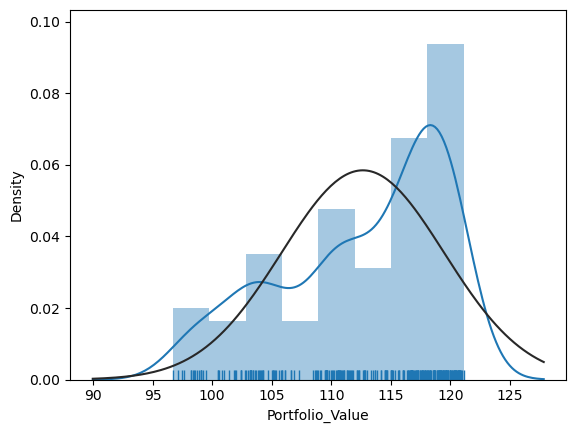

In [9]:
sb.distplot(stock_ret['Portfolio_Value'], kde=True, rug= True, fit=sp.stats.norm)
# sb.set(rc={'figure.figsize':(20,20)})
plt.show()

### Performance Evaluation with a Benchmark

In [10]:
benchmark_series = pd.read_csv('index_level_results_rounded.csv')
benchmark_series = benchmark_series.rename(columns={'index_level':'benchmark'})

benchmark_series['Date'] = pd.to_datetime(benchmark_series['Date'], dayfirst=True)
benchmark_series.set_index('Date', inplace=True)
benchmark_series.sort_index(inplace=True)
benchmark_series = pd.concat([benchmark_series,stock_ret[['Cal_Index']]],axis=1)

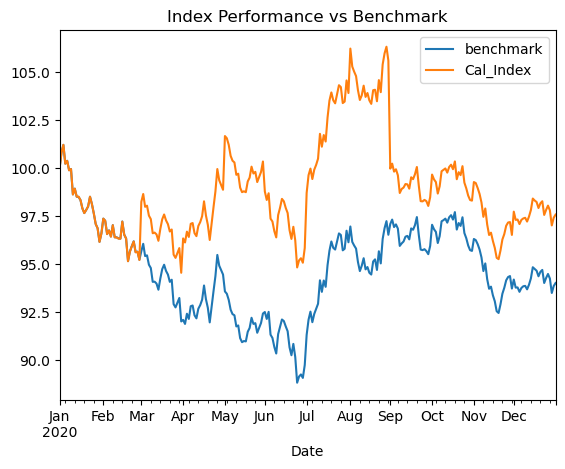

In [11]:
benchmark_series.plot()
plt.title('Index Performance vs Benchmark')
plt.show()

### Try-out Un-supervised Portfolio Optimization Methods to Compare Results

#### Allocation with Non-negative Matrix Factorization (NMF)

unsupervised NMF method is able to learn the representation of the data via a single principal component. The principal component will be a linear combination of the assets such that the coeffs will be non-negative due to the constraints in this algo. 

In [12]:
from sklearn.decomposition import NMF

In [13]:
df=pd.read_csv('stock_prices.csv')
df=df[1:25]

df['Date'] = pd.to_datetime(df['Date'],dayfirst=True)
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)
df=df[1:]

In [14]:
nmf = NMF(n_components=1)
nmf.fit(df)
coeffs = nmf.components_.tolist()[0]
leverage_factor = sum(coeffs)
weights = dict(zip(list(df.columns), np.divide(coeffs,sum(coeffs))))

In [15]:
s1 = ''
for component,weight in weights.items():
    s1 += str(round(weight,5))+'*'+component+" + "
s1 = s1[:-3]

In [16]:
allocation = pd.DataFrame({'Component':list(weights.keys()),'Weight':list(weights.values())})

In [17]:
allocation

,Component,Weight
0,Stock_A,0.100478
1,Stock_B,0.095777
2,Stock_C,0.100973
3,Stock_D,0.099761
4,Stock_E,0.097754
5,Stock_F,0.100689
6,Stock_G,0.102674
7,Stock_H,0.101010
8,Stock_I,0.099490
9,Stock_J,0.101393


In [18]:
l = allocation['Weight'].to_list()
df.loc[:, df.columns.to_list()] *= np.array(l)
df['portfolio_value'] = df[df.columns.to_list()].sum(axis=1)

In [19]:
df['NMF_index']=df['portfolio_value']/df['portfolio_value'][0]*100

In [20]:
df_ = pd.concat([df[['NMF_index']],stock_ret[['Cal_Index']][0:24]],axis=1)

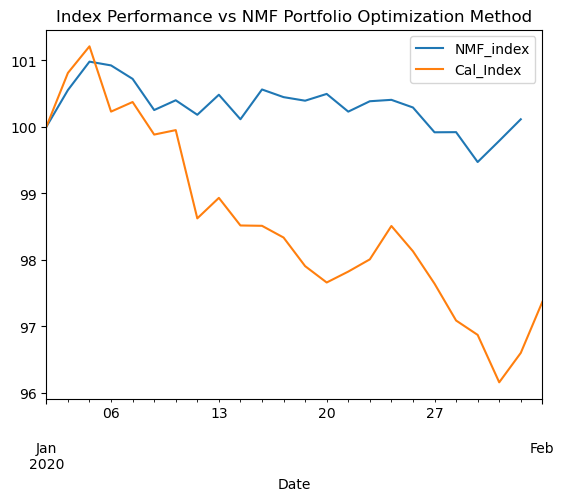

In [21]:
df_.plot()
plt.title('Index Performance vs NMF Portfolio Optimization Method')
plt.show()